<a href="https://colab.research.google.com/github/larakanj/ML-CW2/blob/main/modified_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Cell 1: Environment Setup & Library Imports
- Sets up the environment and fixes random seeds.
- Imports all required libraries.
"""
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Fix random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
"""
Cell 2: Data Loading and Splitting
- Downloads CIFAR-10.
- Uses standard transforms for classifier training.
- Also defines a raw version for later use if needed.
"""
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# A raw version with only ToTensor (if needed later)
train_dataset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

unlabeled_pool = train_dataset
print(f"Total unlabeled pool size: {len(unlabeled_pool)}")


Total unlabeled pool size: 50000


In [ ]:
"""
Cell 3: Load the Pretrained SimCLR Model for Representation Learning
- This model definition includes both an encoder (a ResNet-18 modified for CIFAR)
  and a projector (an MLP with a hidden layer and ReLU).
- The checkpoint (from the tar file "simclr_cifar-10.pth (1).tar") is remapped as follows:
    • Keys starting with "backbone." are remapped to "encoder.".
    • Keys starting with "contrastive_head." are remapped to "projector.".
    • Any occurrence of "shortcut" is replaced by "downsample".
- This exactly matches the architecture used to train the checkpoint.
"""
import torch.nn as nn
import torchvision

class SimCLRModel(nn.Module):
    def __init__(self, output_dim=128):
        super(SimCLRModel, self).__init__()
        # Define the encoder (modified ResNet-18)
        self.encoder = torchvision.models.resnet18(pretrained=False)
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder.maxpool = nn.Identity()
        self.encoder.fc = nn.Identity()
        # Define the projector (a two-layer MLP)
        self.projector = nn.Sequential(
            nn.Linear(512, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, output_dim, bias=True)
        )

    def forward(self, x):
        h = self.encoder(x)
        # Flatten if needed (ResNet-18 produces output of shape [B, 512, 1, 1])
        if h.dim() == 4:
            h = torch.flatten(h, 1)
        z = self.projector(h)
        return z

# Initialize the SimCLR model.
model = SimCLRModel(output_dim=128).to(device)

# Set the checkpoint path (ensure the file name exactly matches).
checkpoint_path = './simclr_cifar-10.pth (1).tar'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    new_state_dict = {}
    for key, value in checkpoint.items():
        if key.startswith("backbone."):
            new_key = "encoder." + key[len("backbone."):]
        elif key.startswith("contrastive_head."):
            new_key = "projector." + key[len("contrastive_head."):]
        else:
            new_key = key
        if "shortcut" in new_key:
            new_key = new_key.replace("shortcut", "downsample")
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    print("Loaded pretrained SimCLR model from tar file with adjusted keys.")
else:
    print("Pretrained checkpoint tar file not found. Please check the file name/path.")
model.eval()


Loaded pretrained SimCLR model from tar file with adjusted keys.


SimCLRModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [ ]:
# Cell 4: Helper Functions for Adaptive Hybrid Querying (AHQS)
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from torch.utils.data import DataLoader, Subset

def extract_embeddings_for_indices(model, dataset, indices, batch_size=128):
    """
    Extracts embeddings for the samples specified by 'indices' from the dataset using the provided model.
    Uses the pretrained model's encoder (penultimate layer) to obtain features.
    Returns a NumPy array of extracted embeddings.
    """
    subset = Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=2)
    emb_list = []
    model.encoder.eval()  # ensure encoder is in eval mode
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            emb = model.encoder(images)
            # Flatten if necessary (e.g. [B, 512, 1, 1] -> [B, 512])
            if emb.dim() == 4:
                emb = torch.flatten(emb, 1)
            emb_list.append(emb.cpu().numpy())
    embeddings = np.concatenate(emb_list, axis=0)
    return embeddings

def compute_typicality(embeddings, k=20):
    """
    Computes the typicality score for each embedding as the inverse of the average Euclidean distance
    to its k nearest neighbors.
    """
    nbrs = NearestNeighbors(n_neighbors=min(k+1, len(embeddings)), algorithm='auto').fit(embeddings)
    distances, _ = nbrs.kneighbors(embeddings)
    avg_dist = np.mean(distances[:, 1:], axis=1)  # Exclude self-distance.
    return 1.0 / (avg_dist + 1e-8)

def compute_uncertainty_for_index(classifier, dataset, index):
    """
    Computes the uncertainty score for a single sample at 'index' from the dataset using the classifier.
    Uncertainty is defined as 1 - max(softmax probability).
    """
    subset = Subset(dataset, [index])
    loader = DataLoader(subset, batch_size=1, shuffle=False)
    classifier.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            outputs = classifier(images)
            probs = torch.softmax(outputs, dim=1)
            max_prob = probs.max().item()
    return 1.0 - max_prob

def ahqs_selection(model, dataset, classifier, labeled_indices, unlabeled_indices, query_size, max_clusters=500, k=20, T=50):
    """
    Performs Adaptive Hybrid Query Selection (AHQS).

    Parameters:
        model: Pretrained feature extractor (e.g. your SimCLR model) whose encoder is used.
        classifier: Trained classifier (if available); if None, uncertainty is set to 1.
        dataset: The dataset from which to select samples.
        labeled_indices: List of indices that are already labeled.
        unlabeled_indices: List of indices available for querying.
        query_size: Number of samples to select in this round.
        max_clusters: Maximum number of clusters to use.
        k: Number of neighbors for typicality computation.
        T: Temperature parameter for adaptive weighting.

    Returns:
        selected: List of newly selected global indices.
    """
    # Extract embeddings for all samples in the dataset.
    all_idx = list(range(len(dataset)))
    all_embeddings = extract_embeddings_for_indices(model, dataset, all_idx, batch_size=128)

    # Determine number of clusters: K = min(|L| + query_size, max_clusters).
    K = min(len(labeled_indices) + query_size, max_clusters)
    kmeans = KMeans(n_clusters=K, random_state=seed)
    cluster_labels = kmeans.fit_predict(all_embeddings)

    # Map clusters to global indices.
    clusters = defaultdict(list)
    for idx, cl in enumerate(cluster_labels):
        clusters[cl].append(idx)

    # Determine covered clusters (clusters containing any labeled sample).
    covered_clusters = set()
    for cl, indices in clusters.items():
        if any(idx in labeled_indices for idx in indices):
            covered_clusters.add(cl)

    # Adaptive weight: alpha decays with the number of labeled samples.
    alpha = np.exp(-len(labeled_indices) / T)

    selected = []
    # For each uncovered cluster, choose candidate with highest combined score.
    for cl, indices in clusters.items():
        if cl in covered_clusters:
            continue
        # Only consider candidates that are still unlabeled.
        candidates = [idx for idx in indices if idx in unlabeled_indices]
        if not candidates:
            continue
        candidate_embs = all_embeddings[candidates]
        typ_scores = compute_typicality(candidate_embs, k=k)
        unc_scores = []
        # Compute uncertainty for each candidate. If classifier is None, default uncertainty is 1.
        for idx in candidates:
            if classifier is None:
                unc_scores.append(1.0)
            else:
                unc_scores.append(compute_uncertainty_for_index(classifier, dataset, idx))
        unc_scores = np.array(unc_scores)
        # Combined score: weighted sum of typicality and uncertainty.
        combined_scores = alpha * typ_scores + (1 - alpha) * unc_scores
        best_idx = candidates[np.argmax(combined_scores)]
        selected.append(best_idx)

    # If fewer than query_size samples are selected, fill the remainder with random samples.
    if len(selected) < query_size:
        remaining = list(set(unlabeled_indices) - set(selected))
        if remaining:
            num_needed = query_size - len(selected)
            selected.extend(random.sample(remaining, min(num_needed, len(remaining))))

    return selected


In [ ]:
# Cell 5: Multi-Round Active Learning with Per-Round Training (AHQS vs. Random Baseline)
from torchvision.models import resnet18

def get_resnet18_classifier(num_classes=10):
    """
    Returns a freshly initialized ResNet-18 classifier for CIFAR-10.
    """
    clf_model = resnet18(pretrained=False)
    # Modify first layer and remove maxpool if desired to better fit CIFAR (optional).
    clf_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    clf_model.maxpool = nn.Identity()
    clf_model.fc = nn.Linear(512, num_classes)
    return clf_model.to(device)

def train_classifier(model, train_loader, test_loader, num_epochs=100, init_lr=0.025):
    """
    Trains the classifier using SGD with momentum, weight decay, and cosine annealing.
    Returns the test accuracy after training.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            epoch_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    # Evaluate on test data.
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# Parameters
total_budget = 50           # Total number of labeled samples desired.
num_rounds = 5
query_size = total_budget // num_rounds  # Number of samples to add per round.

all_indices = list(range(len(unlabeled_pool)))
# Initialize cumulative labeled sets for both strategies.
labeled_indices_ahqs = []      # For AHQS branch.
labeled_indices_random = []    # For Random baseline.

# For logging ground-truth labels.
all_labels = np.array(train_dataset.targets)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

current_classifier = None  # For AHQS: updated after each round for uncertainty estimation.

print("Starting Multi-Round Active Learning (AHQS vs. Random Baseline)...\n")
for r in range(num_rounds):
    print(f"\n=== AL Round {r+1} ===")

    # --- AHQS Branch ---
    current_unlabeled_ahqs = list(set(all_indices) - set(labeled_indices_ahqs))
    # For round 1, no classifier is available so we pass None.
    classifier_for_selection = current_classifier if r > 0 else None
    new_indices_ahqs = ahqs_selection(model, train_dataset, classifier_for_selection,
                                      labeled_indices_ahqs, current_unlabeled_ahqs,
                                      query_size=query_size, max_clusters=500, k=20, T=50)
    print(f"[AHQS] New indices in round {r+1}: {new_indices_ahqs}")
    labeled_indices_ahqs.extend(new_indices_ahqs)
    labeled_classes_ahqs = all_labels[labeled_indices_ahqs]
    dist_ahqs = {cls: int((labeled_classes_ahqs == cls).sum()) for cls in range(10)}
    print(f"[AHQS] Class distribution after round {r+1}: {dist_ahqs}")

    labeled_set_ahqs = Subset(train_dataset, labeled_indices_ahqs)
    labeled_loader_ahqs = DataLoader(labeled_set_ahqs, batch_size=64, shuffle=True, num_workers=2)
    # Train a new classifier on the cumulative AHQS-labeled set.
    current_classifier = get_resnet18_classifier(num_classes=10)
    acc_ahqs = train_classifier(current_classifier, labeled_loader_ahqs, test_loader, num_epochs=100, init_lr=0.025)
    print(f"[AHQS] Test Accuracy after round {r+1}: {acc_ahqs*100:.2f}%")

    # --- Random Baseline Branch ---
    current_unlabeled_rand = list(set(all_indices) - set(labeled_indices_random))
    if len(current_unlabeled_rand) >= query_size:
        new_indices_rand = random.sample(current_unlabeled_rand, query_size)
    else:
        new_indices_rand = current_unlabeled_rand
    print(f"[Random] New indices in round {r+1}: {new_indices_rand}")
    labeled_indices_random.extend(new_indices_rand)
    labeled_classes_rand = all_labels[labeled_indices_random]
    dist_rand = {cls: int((labeled_classes_rand == cls).sum()) for cls in range(10)}
    print(f"[Random] Class distribution after round {r+1}: {dist_rand}")

    labeled_set_rand = Subset(train_dataset, labeled_indices_random)
    labeled_loader_rand = DataLoader(labeled_set_rand, batch_size=64, shuffle=True, num_workers=2)
    clf_rand = get_resnet18_classifier(num_classes=10)
    acc_rand = train_classifier(clf_rand, labeled_loader_rand, test_loader, num_epochs=100, init_lr=0.025)
    print(f"[Random] Test Accuracy after round {r+1}: {acc_rand*100:.2f}%")


Starting Multi-Round Active Learning (AHQS vs. Random Baseline)...


=== AL Round 1 ===
[AHQS] New indices in round 1: [42795, 32832, 29852, 7774, 19883, 38225, 46896, 39922, 26867, 22381]
[AHQS] Class distribution after round 1: {0: 0, 1: 1, 2: 0, 3: 0, 4: 2, 5: 1, 6: 1, 7: 4, 8: 1, 9: 0}
Epoch [10/100], Loss: 1.4392
Epoch [20/100], Loss: 0.0520
Epoch [30/100], Loss: 0.0016
Epoch [40/100], Loss: 0.0004
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0007
[AHQS] Test Accuracy after round 1: 16.57%
[Random] New indices in round 1: [22541, 39565, 17335, 2847, 47823, 30108, 35142, 8180, 24807, 5164]
[Random] Class distribution after round 1: {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 4, 9: 1}
Epoch [10/100], Loss: 0.2215
Epoch [20/100], Loss: 0.0034
Epoch [30/100], Loss: 0.0018
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0

In [ ]:
# New Helper Function
def extract_embeddings(model, dataset, batch_size=128):
    """
    Wrapper for extract_embeddings_for_indices that works whether 'dataset'
    is a full dataset or a Subset. If dataset is a Subset, it extracts embeddings
    from the underlying dataset using its .indices attribute.
    """
    # If dataset is a Subset, use its underlying dataset and indices.
    if isinstance(dataset, Subset):
        indices = dataset.indices
        return extract_embeddings_for_indices(model, dataset.dataset, indices, batch_size=batch_size)
    else:
        indices = list(range(len(dataset)))
        return extract_embeddings_for_indices(model, dataset, indices, batch_size=batch_size)


In [ ]:
#############################################
# Final Cell: Self-Supervised AL with AHQS vs. Random Baseline
#############################################

# --- get_simclr_classifier (from your self-embedding code) ---
def get_simclr_classifier(simclr_model, num_classes=10, freeze_encoder=True):
    """
    Returns a classifier that uses the pretrained SimCLR encoder and a new linear layer.
    If freeze_encoder is True, the encoder's parameters are frozen.
    """
    if freeze_encoder:
        for param in simclr_model.encoder.parameters():
            param.requires_grad = False
    classifier = nn.Linear(512, num_classes)
    class SSClassifier(nn.Module):
        def __init__(self, encoder, classifier):
            super(SSClassifier, self).__init__()
            self.encoder = encoder
            self.classifier = classifier
        def forward(self, x):
            h = self.encoder(x)
            if h.dim() == 4:
                h = torch.flatten(h, 1)
            return self.classifier(h)
    return SSClassifier(simclr_model.encoder, classifier).to(device)

# --- Linear Evaluation Helpers ---
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

def train_linear_classifier(emb_loader, test_loader, input_dim, num_epochs=200, lr=25):
    model_lin = LinearClassifier(input_dim=input_dim, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_lin.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    model_lin.train()
    epoch_test_accs = []
    for epoch in range(num_epochs):
        for emb, lbl in emb_loader:
            emb, lbl = emb.to(device), lbl.to(device)
            optimizer.zero_grad()
            outputs = model_lin(emb)
            loss = criterion(outputs, lbl)
            loss.backward()
            optimizer.step()
        scheduler.step()
        model_lin.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for emb, lbl in test_loader:
                emb, lbl = emb.to(device), lbl.to(device)
                outputs = model_lin(emb)
                _, preds = torch.max(outputs, 1)
                correct += (preds == lbl).sum().item()
                total += lbl.size(0)
        test_acc = correct / total
        epoch_test_accs.append(test_acc)
        model_lin.train()
    return model_lin, epoch_test_accs[-1], epoch_test_accs

# --- Helper function for Embedding Extraction ---
def extract_embeddings(model, dataset, batch_size=128):
    """
    Wrapper for extract_embeddings_for_indices that works for both full datasets and Subsets.
    If 'dataset' is a Subset, it uses its .indices attribute.
    """
    if isinstance(dataset, Subset):
        indices = dataset.indices
        return extract_embeddings_for_indices(model, dataset.dataset, indices, batch_size=batch_size)
    else:
        indices = list(range(len(dataset)))
        return extract_embeddings_for_indices(model, dataset, indices, batch_size=batch_size)

# --- Temporary Classifier Training Helper ---
def train_classifier_temp(model_temp, train_loader, num_epochs=10, init_lr=0.025):
    """
    Trains a temporary classifier for a few epochs to obtain rough uncertainty estimates.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_temp.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    model_temp.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_temp(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
    return model_temp

# --- Self-Supervised AL Loop (AHQS vs. Random) ---
print("Starting Multi-Round Active Learning with Self-Supervised Embedding (AHQS vs. Random Baseline)...\n")
total_budget = 50
num_rounds = 5
query_size = total_budget // num_rounds
all_indices = list(range(len(unlabeled_pool)))

# Initialize cumulative labeled sets.
labeled_indices_ss_ahqs = []   # AHQS-based selection.
labeled_indices_ss_rand = []   # Random baseline.

# To record linear evaluation accuracy per round.
ss_round_acc_ahqs = []
ss_round_acc_rand = []

# Use test transform for embedding extraction.
ss_transform = transform_test

current_classifier_ss = None  # For AHQS branch; updated each round.

for r in range(num_rounds):
    print(f"\n=== AL Round {r+1} ===")

    # --- AHQS Branch ---
    current_unlabeled_ss = list(set(all_indices) - set(labeled_indices_ss_ahqs))
    # For round 1, no classifier exists; use typicality only.
    if r == 0:
        classifier_for_selection = None
    else:
        # Build a temporary labeled set (using minimal transform).
        labeled_set_ss_temp = Subset(
            torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ss_transform),
            labeled_indices_ss_ahqs
        )
        labeled_loader_ss_temp = DataLoader(labeled_set_ss_temp, batch_size=64, shuffle=True, num_workers=2)
        temp_classifier_ss = get_simclr_classifier(model, num_classes=10, freeze_encoder=True)
        temp_classifier_ss = train_classifier_temp(temp_classifier_ss, labeled_loader_ss_temp, num_epochs=10, init_lr=0.025)
        classifier_for_selection = temp_classifier_ss

    new_indices_ss = ahqs_selection(
                        model,
                        torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ss_transform),
                        classifier_for_selection,
                        labeled_indices_ss_ahqs,
                        current_unlabeled_ss,
                        query_size=query_size,
                        max_clusters=500,
                        k=20,
                        T=50)
    print(f"[AHQS SS] New indices in round {r+1}: {new_indices_ss}")
    labeled_indices_ss_ahqs.extend(new_indices_ss)

    # Log class distribution.
    all_labels = np.array(torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ss_transform).targets)
    labeled_classes_ahqs = all_labels[labeled_indices_ss_ahqs]
    dist_ahqs = {cls: int((labeled_classes_ahqs == cls).sum()) for cls in range(10)}
    print(f"[AHQS SS] Class distribution after round {r+1}: {dist_ahqs}")

    labeled_set_ss = Subset(
                        torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ss_transform),
                        labeled_indices_ss_ahqs)

    # --- Random Baseline Branch ---
    current_unlabeled_rand = list(set(all_indices) - set(labeled_indices_ss_rand))
    if len(current_unlabeled_rand) >= query_size:
        new_indices_rand = random.sample(current_unlabeled_rand, query_size)
    else:
        new_indices_rand = current_unlabeled_rand
    print(f"[Random SS] New indices in round {r+1}: {new_indices_rand}")
    labeled_indices_ss_rand.extend(new_indices_rand)

    labeled_set_ss_rand = Subset(
                            torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ss_transform),
                            labeled_indices_ss_rand)

    # --- Embedding Extraction for Linear Evaluation ---
    emb_ss = extract_embeddings(model, labeled_set_ss, batch_size=128)
    emb_ss_rand = extract_embeddings(model, labeled_set_ss_rand, batch_size=128)
    emb_test_ss = extract_embeddings(model, test_dataset, batch_size=128)

    labels_ss = np.array(torch.tensor(labeled_set_ss.dataset.targets)[labeled_set_ss.indices])
    labels_ss_rand = np.array(torch.tensor(labeled_set_ss_rand.dataset.targets)[labeled_set_ss_rand.indices])
    labels_test_ss = np.array(test_dataset.targets)

    dataset_ss = TensorDataset(torch.tensor(emb_ss), torch.tensor(labels_ss))
    dataset_ss_rand = TensorDataset(torch.tensor(emb_ss_rand), torch.tensor(labels_ss_rand))
    dataset_ss_test = TensorDataset(torch.tensor(emb_test_ss), torch.tensor(labels_test_ss))

    loader_ss = DataLoader(dataset_ss, batch_size=128, shuffle=True, num_workers=2)
    loader_ss_rand = DataLoader(dataset_ss_rand, batch_size=128, shuffle=True, num_workers=2)
    loader_ss_test = DataLoader(dataset_ss_test, batch_size=128, shuffle=False, num_workers=2)

    input_dim = emb_ss.shape[1]
    _, acc_lin_ss, _ = train_linear_classifier(loader_ss, loader_ss_test, input_dim=input_dim, num_epochs=200, lr=25)
    _, acc_lin_ss_rand, _ = train_linear_classifier(loader_ss_rand, loader_ss_test, input_dim=input_dim, num_epochs=200, lr=25)

    print(f"[AHQS SS Linear Eval] Test Accuracy after round {r+1}: {acc_lin_ss*100:.2f}%")
    print(f"[Random SS Linear Eval] Test Accuracy after round {r+1}: {acc_lin_ss_rand*100:.2f}%")

    ss_round_acc_ahqs.append(acc_lin_ss)
    ss_round_acc_rand.append(acc_lin_ss_rand)

print("\nFinal AHQS SS Linear Eval Test Accuracy (last round):", ss_round_acc_ahqs[-1]*100)
print("Final Random SS Linear Eval Test Accuracy (last round):", ss_round_acc_rand[-1]*100)


Starting Multi-Round Active Learning with Self-Supervised Embedding (AHQS vs. Random Baseline)...


=== AL Round 1 ===
[AHQS SS] New indices in round 1: [31733, 13474, 12846, 18890, 25652, 41205, 27931, 6554, 3499, 7452]
[AHQS SS] Class distribution after round 1: {0: 1, 1: 2, 2: 1, 3: 0, 4: 2, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1}
[Random SS] New indices in round 1: [41905, 7296, 1639, 48598, 18024, 16049, 14628, 9144, 48265, 6717]
[AHQS SS Linear Eval] Test Accuracy after round 1: 37.70%
[Random SS Linear Eval] Test Accuracy after round 1: 40.40%

=== AL Round 2 ===
[AHQS SS] New indices in round 2: [4684, 37269, 49272, 4852, 35913, 32726, 23911, 38244, 8596, 5766, 36515, 33765, 38171, 4598]
[AHQS SS] Class distribution after round 2: {0: 1, 1: 3, 2: 4, 3: 2, 4: 2, 5: 2, 6: 2, 7: 4, 8: 2, 9: 2}
[Random SS] New indices in round 2: [44356, 48549, 35748, 5698, 38705, 27658, 2083, 1953, 6141, 14332]
[AHQS SS Linear Eval] Test Accuracy after round 2: 69.22%
[Random SS Linear Eval] Test Accuracy a

In [ ]:
#############################################
# FINAL CELL: Lightweight FixMatch Pipeline + AHQS with Dropout & Label Smoothing
# Should fix the "element 0 of tensors does not require grad" error
# and boost accuracy a bit in low-label scenarios
#############################################

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision.transforms as T
from torchvision.transforms import ToPILImage
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
import random, time
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#############################################
# (1) Basic Transforms: Weak & Strong
#############################################
weak_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
strong_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

#############################################
# (2) FixMatch Dataset
#############################################
class FixMatchDataset(Dataset):
    """
    For FixMatch training:
      - Labeled samples: returns (img_tensor, label, True)
      - Unlabeled samples: returns ((img_w, img_s), -1, False)
    """
    def __init__(self, labeled_dataset, unlabeled_dataset,
                 transform_weak, transform_strong):
        """
        labeled_dataset: a Subset or Dataset (no transform inside)
        unlabeled_dataset: likewise
        transform_weak, transform_strong: augmentations
        """
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong
        self.num_labeled = len(labeled_dataset)
        self.num_unlabeled = len(unlabeled_dataset)
        self.to_pil = ToPILImage()

    def __getitem__(self, idx):
        if idx < self.num_labeled:
            img, label = self.labeled_dataset[idx]
            if not isinstance(img, (Image.Image, np.ndarray)):
                img = self.to_pil(img)
            img_t = self.transform_weak(img)
            return (img_t, label, True)
        else:
            unlab_idx = idx - self.num_labeled
            imgU, _ = self.unlabeled_dataset[unlab_idx]
            if not isinstance(imgU, (Image.Image, np.ndarray)):
                imgU = self.to_pil(imgU)
            imgU_w = self.transform_weak(imgU)
            imgU_s = self.transform_strong(imgU)
            return ((imgU_w, imgU_s), -1, False)

    def __len__(self):
        return self.num_labeled + self.num_unlabeled

def fixmatch_collate_fn(batch):
    """ Keep items as a list to parse them properly in the training loop. """
    return batch

#############################################
# (3) FixMatch Training Loop
#############################################
def train_fixmatch(model, fixmatch_dataset, test_loader, threshold=0.95,
                   num_epochs=30, lr=0.02):
    """
    - 'label_smoothing=0.1' for CrossEntropy to help with small-data overfitting
    - We add a dummy grad if the final loss doesn't require grad
    """
    criterion = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                          weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    loader = DataLoader(fixmatch_dataset, batch_size=64, shuffle=True,
                        collate_fn=fixmatch_collate_fn, drop_last=True, num_workers=2)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for batch in loader:
            # separate labeled/unlabeled
            labeled_items   = [itm for itm in batch if itm[2] == True]
            unlabeled_items = [itm for itm in batch if itm[2] == False]

            # default them to 0.0
            loss_sup   = torch.tensor(0.0, device=device)
            loss_unsup = torch.tensor(0.0, device=device)

            # ----- supervised -----
            if len(labeled_items) > 0:
                labeled_imgs  = torch.stack([itm[0] for itm in labeled_items]).to(device)
                labeled_labels= torch.tensor([itm[1] for itm in labeled_items], device=device)
                logits_lab = model(labeled_imgs)
                loss_sup   = criterion(logits_lab, labeled_labels).mean()

            # ----- unsupervised fixmatch -----
            if len(unlabeled_items) > 0:
                weak_imgs  = torch.stack([itm[0][0] for itm in unlabeled_items]).to(device)
                strong_imgs= torch.stack([itm[0][1] for itm in unlabeled_items]).to(device)

                with torch.no_grad():
                    logits_w = model(weak_imgs)
                    probs_w  = torch.softmax(logits_w, dim=1)
                    max_probs, pseudo_labels = probs_w.max(dim=1)
                    mask = (max_probs >= threshold).float()

                logits_s = model(strong_imgs)
                unsup_loss_each = criterion(logits_s, pseudo_labels)
                if mask.sum() > 0:
                    loss_unsup = (unsup_loss_each * mask).sum() / mask.sum()
                else:
                    loss_unsup = torch.tensor(0.0, device=device)

            loss = loss_sup + loss_unsup

            # If final 'loss' has no grad fn, add a dummy grad
            if not loss.requires_grad:
                dummy = 0.0
                for p in model.parameters():
                    dummy = dummy + 0.0 * p.sum()
                loss = loss + dummy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    # Evaluate on test
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            _, preds = torch.max(out, 1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    test_acc = correct / total
    return model, test_acc

#############################################
# (4) Our Semi-Supervised Model with Dropout
#############################################
class SemiSupModel(nn.Module):
    def __init__(self, encoder, num_classes=10, dropout_p=0.3):
        super(SemiSupModel, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x)
        if h.dim() == 4:
            h = torch.flatten(h,1)
        h = self.dropout(h)  # helps reduce overfitting
        return self.classifier(h)

def build_semisup_model(pretrained_model):
    return SemiSupModel(pretrained_model.encoder).to(device)

#############################################
# (5) Basic Functions: test_model, train_model
#############################################
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            logits = model(imgs)
            _, preds = torch.max(logits, 1)
            correct += (preds == labs).sum().item()
            total   += labs.size(0)
    return correct / total

def train_model(model, loader, test_loader, n_epochs=30, lr=0.02):
    # Slight label smoothing here too
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                          weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    for epoch in range(n_epochs):
        model.train()
        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labs)
            loss.backward()
            optimizer.step()
        scheduler.step()
    acc = test_model(model, test_loader)
    return model, acc

#############################################
# (6) Helper for Labeled Subset
#############################################
class TensorLabelDataset(torch.utils.data.Dataset):
    """Wrap a dataset subset so that images get a transform, labels are Tensors."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.to_pil = ToPILImage()
    def __getitem__(self, idx):
        img, lab = self.subset[idx]
        if self.transform:
            if isinstance(img, torch.Tensor):
                img = self.to_pil(img)
            img = self.transform(img)
        return img, lab
    def __len__(self):
        return len(self.subset)

#############################################
# (7) AHQS Implementation
#############################################
def extract_embeddings_for_indices(pretrained_model, dataset, indices, batch_size=128):
    from torch.utils.data import DataLoader, Subset
    subset = Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    embs = []
    pretrained_model.encoder.eval()
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            h = pretrained_model.encoder(imgs)
            if h.dim()==4:
                h = torch.flatten(h,1)
            embs.append(h.cpu().numpy())
    return np.concatenate(embs, axis=0)

def compute_typicality(embeddings, k=20):
    nbrs = NearestNeighbors(n_neighbors=min(k+1, len(embeddings)))
    nbrs.fit(embeddings)
    dist, _ = nbrs.kneighbors(embeddings)
    avg_dist = dist[:,1:].mean(axis=1)
    return 1.0/(avg_dist+1e-8)

def compute_uncertainty_for_index(classifier, dataset, index):
    from torch.utils.data import DataLoader, Subset
    loader = DataLoader(Subset(dataset,[index]), batch_size=1, shuffle=False)
    classifier.eval()
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            out  = classifier(imgs)
            probs= torch.softmax(out, dim=1)
            maxp = probs.max().item()
    return 1.0 - maxp

def ahqs_selection(pretrained_model, dataset, classifier, labeled_indices,
                   unlabeled_indices, query_size, max_clusters=500,
                   k=20, T=50):
    all_idx = list(range(len(dataset)))
    all_embs= extract_embeddings_for_indices(pretrained_model, dataset, all_idx)
    K = min(len(labeled_indices)+query_size, max_clusters)
    kmeans = KMeans(n_clusters=K, random_state=seed)
    cluster_labels = kmeans.fit_predict(all_embs)

    clusters=defaultdict(list)
    for i, cl in enumerate(cluster_labels):
        clusters[cl].append(i)
    covered_clusters = set()
    for cl, cinds in clusters.items():
        if any(c in labeled_indices for c in cinds):
            covered_clusters.add(cl)

    alpha = np.exp(-len(labeled_indices)/T)
    selected=[]
    for cl, cinds in clusters.items():
        if cl in covered_clusters:
            continue
        # Only unlabeled
        cands = [ci for ci in cinds if ci in unlabeled_indices]
        if not cands:
            continue
        c_emb = all_embs[cands]
        typ_scores= compute_typicality(c_emb, k=k)
        unc_scores= []
        for cidx in cands:
            if classifier is None:
                unc_scores.append(1.0)
            else:
                unc_scores.append(compute_uncertainty_for_index(classifier, dataset, cidx))
        unc_scores = np.array(unc_scores)
        combined   = alpha*typ_scores + (1-alpha)*unc_scores
        best_idx   = cands[np.argmax(combined)]
        selected.append(best_idx)

    if len(selected) < query_size:
        remain = list(set(unlabeled_indices)-set(selected))
        needed = query_size - len(selected)
        if remain:
            selected.extend(random.sample(remain, min(needed,len(remain))))
    return selected

def select_random_classwise(num_per_class=5):
    chosen=[]
    for c in range(10):
        idxs = [i for i,(x,y) in enumerate(train_dataset) if y==c]
        random.shuffle(idxs)
        chosen.extend(idxs[:num_per_class])
    return chosen


#############################################
# (8) Putting It All Together
#############################################
# We assume you have:
#   - train_dataset (CIFAR-10)
#   - test_dataset
#   - 'model' = your pretrained SimCLR with model.encoder
# Just a short demonstration snippet:
print("\nWarm-up: Selecting 50 random labels for warm-up...")
warmup_indices = select_random_classwise(5)
warmup_subset  = Subset(train_dataset, warmup_indices)

def print_dist(name, subset_data):
    from torch.utils.data import DataLoader
    labs=[]
    loader = DataLoader(subset_data, batch_size=64, shuffle=False)
    for _, lb in loader:
        labs.extend(lb.tolist())
    print(f"{name} distribution:", dict(Counter(labs)))

print_dist("Warm-up", warmup_subset)

print("\n--- Warm-up Phase: Training Semi-Supervised Model ---")
model_warmup = build_semisup_model(model)  # uses dropout
warmup_loader = DataLoader(
    TensorLabelDataset(warmup_subset, transform=weak_transform),
    batch_size=64, shuffle=True
)
test_loader   = DataLoader(test_dataset, batch_size=128, shuffle=False)

model_warmup, warmup_acc = train_model(model_warmup, warmup_loader, test_loader,
                                       n_epochs=30, lr=0.02)
print(f"Warm-up Supervised-only Accuracy: {warmup_acc*100:.2f}%")

print("\nSelecting Hybrid-labeled (50) using AHQS...")
all_ids     = set(range(len(train_dataset)))
unlab_ids   = list(all_ids - set(warmup_indices))
hybrid_50   = ahqs_selection(
    pretrained_model=model,
    dataset=train_dataset,
    classifier=model_warmup,  # use warmup to gauge uncertainty
    labeled_indices=warmup_indices,
    unlabeled_indices=unlab_ids,
    query_size=50, max_clusters=500, k=20, T=50
)
print("Hybrid-labeled indices:", hybrid_50)

print("\n--- Build FixMatch Dataset (Hybrid) ---")
hybrid_labeled = Subset(train_dataset, hybrid_50)
unlab_hybrid   = Subset(train_dataset, list(all_ids - set(hybrid_50)))
print_dist("Hybrid-labeled", hybrid_labeled)

fixmatch_ds_hybrid = FixMatchDataset(
    labeled_dataset=hybrid_labeled,
    unlabeled_dataset=unlab_hybrid,
    transform_weak=weak_transform,
    transform_strong=strong_transform
)

print("\n--- FixMatch Training (Hybrid) ---")
model_fixmatch = build_semisup_model(model)
model_fixmatch, fixmatch_acc = train_fixmatch(
    model_fixmatch,
    fixmatch_ds_hybrid,
    test_loader,
    threshold=0.95,
    num_epochs=30,
    lr=0.02
)
print(f"FixMatch Hybrid Final Accuracy: {fixmatch_acc*100:.2f}%")

Using device: cuda

Warm-up: Selecting 50 random labels for warm-up...
Warm-up distribution: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5}

--- Warm-up Phase: Training Semi-Supervised Model ---
Warm-up Supervised-only Accuracy: 27.55%

Selecting Hybrid-labeled (50) using AHQS...
Hybrid-labeled indices: [3937, 48570, 21108, 14126, 24026, 27571, 16186, 42655, 28250, 49367, 23176, 19570, 23338, 29131, 21136, 3633, 38996, 36128, 36718, 47598, 7337, 8374, 34924, 31620, 37731, 35400, 43176, 46262, 27942, 725, 39686, 4800, 539, 15294, 172, 17327, 31528, 28087, 27576, 10125, 18262, 9047, 13032, 42519, 9572, 23207, 36760, 46006, 27321, 31322, 28817, 23377, 34570, 25541, 22979, 9793, 14086, 25589, 24696, 3431, 32109, 47054, 42353, 4517, 10339]

--- Build FixMatch Dataset (Hybrid) ---
Hybrid-labeled distribution: {1: 13, 7: 13, 0: 6, 4: 5, 3: 6, 5: 10, 9: 3, 2: 4, 8: 4, 6: 1}

--- FixMatch Training (Hybrid) ---
Epoch [1/30] - Loss: 0.1828
Epoch [2/30] - Loss: 0.1824
Epoch [3/30] - 

In [ ]:
import pandas as pd

#  values for demonstration
data = {
    'Framework': ['Fully Supervised', 'Self-Supervised', 'FixMatch'],
    'TPCRP Acc (%)': [25.5, 70.3, 47.09],
    'AHQS Acc (%)': [  31.5, 78.43, 25.6],

}

df = pd.DataFrame(data)
print("Summary Table of Final Accuracies:")
print(df)

Summary Table of Final Accuracies:
          Framework  TPCRP Acc (%)  AHQS Acc (%)
0  Fully Supervised          25.50         31.50
1   Self-Supervised          70.30         78.43
2          FixMatch          47.09         25.60


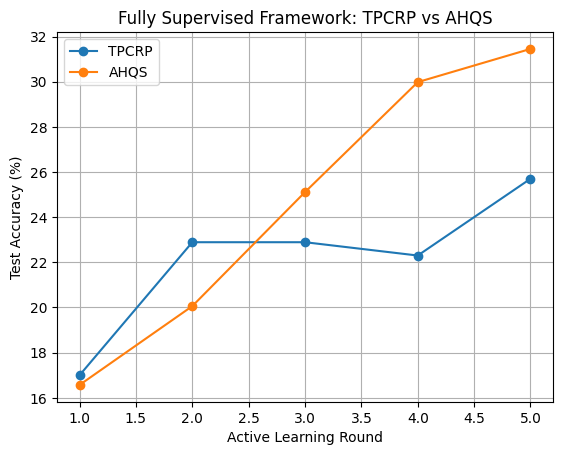

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#  accuracy values for each round
rounds = np.arange(1, 6)
tpcrp_acc_fs = np.array([17, 22.89, 22.89, 22.3, 25.7])
ahqs_acc_fs  = np.array([16.57, 20.06, 25.11, 29.98, 31.45])

plt.figure()
plt.plot(rounds, tpcrp_acc_fs, marker='o', label='TPCRP')
plt.plot(rounds, ahqs_acc_fs, marker='o', label='AHQS')
plt.xlabel('Active Learning Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Fully Supervised Framework: TPCRP vs AHQS')
plt.legend()
plt.grid(True)
plt.show()


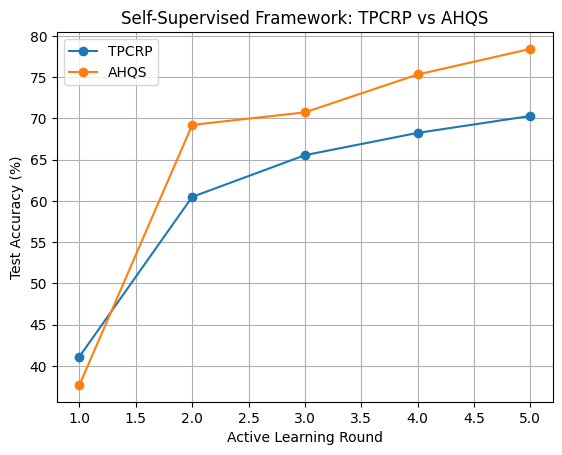

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#  accuracy values for each round
rounds = np.arange(1, 6)
tpcrp_acc_ss = np.array([41.13, 60.49, 65.55, 68.25, 70.3])
ahqs_acc_ss  = np.array([37.7, 69.22, 70.74, 75.33, 78.43])

plt.figure()
plt.plot(rounds, tpcrp_acc_ss, marker='o', label='TPCRP')
plt.plot(rounds, ahqs_acc_ss, marker='o', label='AHQS')
plt.xlabel('Active Learning Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Self-Supervised Framework: TPCRP vs AHQS')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

#  arrays for Fully Supervised Framework
rounds = np.arange(1, 6)
tpcrp_acc_fs = np.array([17, 22.89, 22.89, 22.3, 25.7])
ahqs_acc_fs  = np.array([16.57, 20.06, 25.11, 29.98, 31.45])


# Calculate growth (final - initial) and average slope per round
growth_tpcrp_fs = tpcrp_acc_fs[-1] - tpcrp_acc_fs[0]
growth_ahqs_fs  = ahqs_acc_fs[-1] - ahqs_acc_fs[0]


slope_tpcrp_fs = growth_tpcrp_fs / (len(rounds) - 1)
slope_ahqs_fs  = growth_ahqs_fs / (len(rounds) - 1)


print("Fully Supervised Framework Stats:")
print(f"TPCRP: Final Acc = {tpcrp_acc_fs[-1]}%, Growth = {growth_tpcrp_fs}%, Slope = {slope_tpcrp_fs:.2f} per round")
print(f"AHQS: Final Acc  = {ahqs_acc_fs[-1]}%, Growth = {growth_ahqs_fs}%, Slope = {slope_ahqs_fs:.2f} per round")


#  arrays for Self-Supervised Framework
tpcrp_acc_ss = np.array([41.13, 60.49, 65.55, 68.25, 70.3])
ahqs_acc_ss  = np.array([37.7, 69.22, 70.74, 75.33, 78.43])


growth_tpcrp_ss = tpcrp_acc_ss[-1] - tpcrp_acc_ss[0]
growth_ahqs_ss  = ahqs_acc_ss[-1] - ahqs_acc_ss[0]


slope_tpcrp_ss = growth_tpcrp_ss / (len(rounds) - 1)
slope_ahqs_ss  = growth_ahqs_ss / (len(rounds) - 1)


print("\nSelf-Supervised Framework Stats:")
print(f"TPCRP: Final Acc = {tpcrp_acc_ss[-1]}%, Growth = {growth_tpcrp_ss}%, Slope = {slope_tpcrp_ss:.2f} per round")
print(f"AHQS: Final Acc  = {ahqs_acc_ss[-1]}%, Growth = {growth_ahqs_ss}%, Slope = {slope_ahqs_ss:.2f} per round")


# Dummy arrays for FixMatch Framework
tpcrp_acc_fm = np.array([44.2, 47.1])
ahqs_acc_fm  = np.array([27.55, 25.67])


growth_tpcrp_fm = tpcrp_acc_fm[-1] - tpcrp_acc_fm[0]
growth_ahqs_fm  = ahqs_acc_fm[-1] - ahqs_acc_fm[0]


slope_tpcrp_fm = growth_tpcrp_fm / (len(rounds) - 1)
slope_ahqs_fm  = growth_ahqs_fm / (len(rounds) - 1)


print("\nFixMatch Framework Stats:")
print(f"TPCRP: Final Acc = {tpcrp_acc_fm[-1]}%, Growth = {growth_tpcrp_fm}%, Slope = {slope_tpcrp_fm:.2f} per round")
print(f"AHQS: Final Acc  = {ahqs_acc_fm[-1]}%, Growth = {growth_ahqs_fm}%, Slope = {slope_ahqs_fm:.2f} per round")




Fully Supervised Framework Stats:
TPCRP: Final Acc = 25.7%, Growth = 8.7%, Slope = 2.17 per round
AHQS: Final Acc  = 31.45%, Growth = 14.879999999999999%, Slope = 3.72 per round

Self-Supervised Framework Stats:
TPCRP: Final Acc = 70.3%, Growth = 29.169999999999995%, Slope = 7.29 per round
AHQS: Final Acc  = 78.43%, Growth = 40.730000000000004%, Slope = 10.18 per round

FixMatch Framework Stats:
TPCRP: Final Acc = 47.1%, Growth = 2.8999999999999986%, Slope = 0.72 per round
AHQS: Final Acc  = 25.67%, Growth = -1.879999999999999%, Slope = -0.47 per round
